In [3]:
# # Mount Google Drive
# from google.colab import drive
# import shutil
# import sys

# # Mount drive
# drive.mount('/drive', force_remount=True)
# # Set path
# sys.path.append('/drive/My Drive/COMS6998')

# !cp -r '/drive/My Drive/COMS6998/fundamentals.csv' '/fundamentals.csv'
# !cp -r '/drive/My Drive/COMS6998/prices-split-adjusted.csv' '/prices-split-adjusted.csv'
# !cp -r '/drive/My Drive/COMS6998/prices.csv' '/prices.csv'
# !cp -r '/drive/My Drive/COMS6998/data_fund.csv' '/data_fund.csv'


Mounted at /drive


In [4]:
#!pip install pyro-ppl

import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import math

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

In [0]:
# def preprocess():
#   data = pd.read_csv("/data_fund.csv")
#   fun = data.loc[~data['Indicator Name'].isin(['Common Shares Outstanding','Share Price'])].reset_index(drop=True)
#   fun['yyyymm']=pd.to_datetime(fun['publish date'])
#   fun = pd.pivot_table(fun, values='Indicator Value', index=['Ticker', 'yyyymm'],columns=['Indicator Name'], aggfunc=np.mean).reset_index()

#   to_remove = ['Ticker','yyyymm','Avg. Basic Shares Outstanding','Avg. Diluted Shares Outstanding','Total Assets']
#   fun_cols = list(fun.columns)
#   for elem in to_remove:
#     fun_cols.remove(elem)

#   fun[fun_cols] = fun[fun_cols].div(fun['Total Assets'], axis=0).reset_index(drop=True)

#   features = fun[fun_cols+['yyyymm','Ticker']]
#   features = features.dropna().reset_index(drop=True)
#   features = features.fillna(0).reset_index(drop=True)

#   zscore = lambda x: (x - x.mean()) / x.std()
#   final = features[['Ticker','yyyymm']]
#   for item in fun_cols:
#     temp = features.groupby([features.yyyymm])[item].transform(zscore)
#     final = pd.concat([final,temp], axis=1).reset_index(drop=True)

#   data['publish date']=pd.to_datetime(data['publish date'])
#   rtns = data.loc[data['Indicator Name']=='Share Price', ['Ticker','publish date','Company Industry Classification Code', 'Indicator Value']].reset_index(drop=True)
#   rtns.columns = ['Ticker','Date','Industry','Price']
#   # rtns['Rtn1d'] = rtns.groupby('Ticker')['Price'].apply(lambda x: np.log(x).diff())
#   # rtns['Rtn1q'] = rtns.groupby('Ticker')['Rtn1d'].rolling(63).sum().reset_index(0,drop=True)
#   rtns['Rtn1d'] = rtns.groupby('Ticker')['Price'].apply(lambda x: np.log(x).diff())
#   rtns['Rtn1q'] = rtns.groupby('Ticker')['Rtn1d'].rolling(63).sum().shift(-63).reset_index(0,drop=True)
#   rtns['Rtn1d'] = rtns.groupby('Ticker')['Rtn1d'].shift(-1).reset_index(0,drop=True)
#   rtns.dropna(inplace=True)
  
#   final = final.merge(rtns, left_on=['Ticker','yyyymm'], right_on =['Ticker','Date'],how='inner').reset_index(0,drop=True)
#   final.dropna(inplace=True)
#   train = final[final['yyyymm']<='2016-12-31'].reset_index(0,drop=True)
#   test = final[final['yyyymm']>'2016-12-31'].reset_index(0,drop=True)

#   X_train = train[fun_cols].values
#   y_train = train['Rtn1q'].values
#   X_test = test[fun_cols].values
#   y_test = test['Rtn1q'].values
#   X_tr = torch.tensor(X_train, dtype=torch.float)
#   y_tr = torch.tensor(y_train, dtype=torch.float)
#   X_ts = torch.tensor(X_test, dtype=torch.float)
#   y_ts = torch.tensor(y_test, dtype=torch.float)

#   return X_tr,y_tr,X_ts,y_ts

In [6]:
from preprocess import preprocess

X_tr,y_tr,X_ts,y_ts =preprocess()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [0]:
#!pip install http://download.pytorch.org/whl/cpu/torch-0.4.0-cp27-cp27mu-linux_x86_64.whl 
#!pip install pyro-ppl

import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import math

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta, LogNormal
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine


# The true model, with randomly generated weights and fixed noise level
#noise_level = 0.1
x = X_tr
y = y_tr

In [8]:
x.shape

torch.Size([5000, 32])

In [0]:
# class RegressionModel(nn.Module):
#     def __init__(self, p):
#         # p = number of features
#         super(RegressionModel, self).__init__()
#         self.linear = nn.Linear(p, 1)
#    #     self.factor = nn.Parameter(torch.tensor(1.))

#     def forward(self, x):
#       #  print (x.shape)
#         return self.linear(x) #+ (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

# regression_model = RegressionModel(X_tr.shape[1])

# # loc = torch.zeros(1, 1)
# # scale = torch.ones(1, 1)
# # # define a unit normal prior
# # prior = Normal(loc, scale)
# # # overload the parameters in the regression module with samples from the prior
# # lifted_module = pyro.random_module("regression_module", regression_model, prior)
# # # sample a nn from the prior
# # sampled_reg_model = lifted_module()

In [0]:
pyro.enable_validation(True)
pyro.clear_param_store()

In [0]:
# The prior
@config_enumerate
def model(x,y):
  # alpha = torch.tensor(0.0)
  # beta = torch.tensor(1.0)
  # w_prior = pyro.sample( "w_prior",Normal(alpha, beta).expand([11]).to_event(1))
  # w_prior = pyro.sample( 'w_prior',Normal(torch.tensor(0.0), torch.tensor(1.0)).expand([11]).to_event(1)) 
  # b_prior = pyro.sample('b_prior',Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])))
  #w_prior = Normal(torch.tensor(0.0), torch.tensor(1.0)).expand([1,x.shape[1]]).to_event(1)
  # w_prior = Normal(torch.tensor(0.0), torch.tensor(1.0)).expand([x.shape[1]])

  with pyro.plate('locs', x.shape[1]):
    w_prior = pyro.sample('w_prior',Normal(torch.tensor(0.0), torch.tensor(1.0)))
  b_prior = pyro.sample('b_prior',Normal(torch.tensor([1.0]), torch.tensor([5.0])))
  # b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
  w_prior = w_prior.unsqueeze(-1)

  prediction_mean = b_prior + torch.mm(x, w_prior)
  #priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
  sigma = pyro.sample("sigma", LogNormal(0.,5.))

 # lifted_module = pyro.random_module("module", regression_model, priors)
 # lifted_reg_model = lifted_module()

  #mu = a + w_prior*x
  #for i in pyro.plate("data_loop", len(x)):
  with pyro.plate("map", len(x)):
   # prediction_mean = lifted_reg_model(x).squeeze(-1)
    # prediction_mean =  w_prior*x
    pyro.sample("obs", Normal(prediction_mean, sigma), obs=y)


from pyro.infer.autoguide import AutoDiagonalNormal, AutoDelta
from torch.distributions import constraints
guide = AutoDiagonalNormal(model)


In [0]:
def guide(x,y):
    weights_loc = pyro.param('weights_loc', torch.randn(1))#.expand([])
    weights_scale = pyro.param('weights_scale', torch.ones(1), constraint=constraints.positive)        
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.0), constraint=constraints.positive)
    bias_loc = pyro.param('bias_loc', torch.randn(1))#.expand([])
    bias_scale = pyro.param('bias_scale', torch.ones(1), constraint=constraints.positive)        
    # print (pyro.param('weights_scale'))
    # print (pyro.param('bias_scale'))

    with pyro.plate('locs', x.shape[1]):
      w_prior = pyro.sample('w_prior',Normal(weights_loc, weights_scale))
    
    b_prior = pyro.sample('b_prior',Normal(bias_loc, bias_scale))

    sigma = pyro.sample("sigma", LogNormal(sigma_loc, torch.tensor(0.05)))
   # print (b_prior.shape,x.shape, w_prior.shape)
    w_prior = w_prior.unsqueeze(-1)

    prediction_mean = b_prior + torch.mm(x, w_prior)


In [0]:
model(x,y)

In [36]:
svi = pyro.infer.SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=pyro.infer.Trace_ELBO(max_plate_nesting=1), num_samples=1000)

pyro.clear_param_store()
rec_loss = []
for i in range(100):
  loss = svi.step(x,y)
  rec_loss.append(loss)
  print('Iter %d, loss = %g' % (i,loss))

# optimizer = pyro.optim.SGD({"lr": 1e-4, "momentum": 0.1})
# pyro.clear_param_store()
# svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO(max_plate_nesting=1))
# rec_loss = []
# for i in range(100):
#     loss = svi.step(x,y)
#     rec_loss.append(loss)
#     print('Iter %d, loss = %g' % (i,loss))

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:50: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)


Iter 0, loss = 1.3254e+08
Iter 1, loss = 2.53758e+08
Iter 2, loss = 2.14378e+08
Iter 3, loss = 1.44604e+08
Iter 4, loss = 1.10039e+08
Iter 5, loss = 1.49648e+08
Iter 6, loss = 1.5931e+08
Iter 7, loss = 1.97832e+08
Iter 8, loss = 1.72342e+08
Iter 9, loss = 2.11504e+08
Iter 10, loss = 1.47224e+08
Iter 11, loss = 1.47376e+08
Iter 12, loss = 9.99818e+07
Iter 13, loss = 2.17978e+08
Iter 14, loss = 1.88302e+08
Iter 15, loss = 1.67405e+08
Iter 16, loss = 1.716e+08
Iter 17, loss = 1.14035e+08
Iter 18, loss = 1.66675e+08
Iter 19, loss = 1.48783e+08
Iter 20, loss = 1.18059e+08
Iter 21, loss = 1.27915e+08
Iter 22, loss = 1.23322e+08
Iter 23, loss = 1.64241e+08
Iter 24, loss = 1.29224e+08
Iter 25, loss = 1.14584e+08
Iter 26, loss = 1.42492e+08
Iter 27, loss = 1.06735e+08
Iter 28, loss = 1.41669e+08
Iter 29, loss = 1.45931e+08
Iter 30, loss = 1.25862e+08
Iter 31, loss = 1.24712e+08
Iter 32, loss = 1.14253e+08
Iter 33, loss = 1.49764e+08
Iter 34, loss = 1.39396e+08
Iter 35, loss = 1.21925e+08
Iter 3

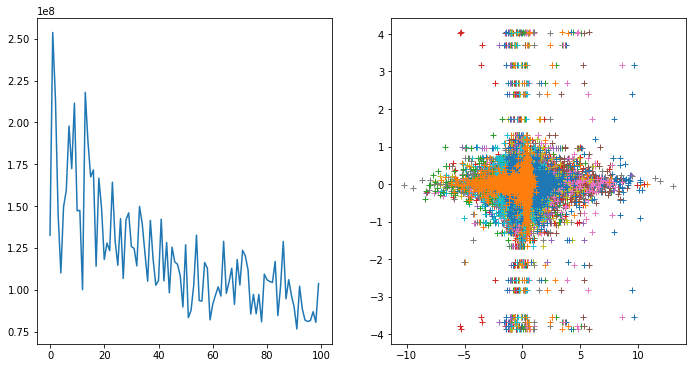

In [37]:
fig = plt.figure(figsize = (18,6))
plt.subplot(131)
plt.plot(rec_loss)

plt.subplot(132)
plt.plot(x.numpy(),y.numpy(),'+')


In [31]:

# estimates = svi.run(x,y)
# sites = ['weights_loc']#, 'weights_scale', 'bias_loc', 'bias_scale','sigma_loc']
# svi_samples = {site: EmpiricalMarginal(estimates, sites=site).enumerate_support().detach().cpu().numpy()
#                        for site in sites}


/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:85: FutureWarning: The `SVI.run` method is deprecated and will be removed in a future release. For inference, use `SVI.step` directly, and for predictions, use the `pyro.infer.Predictive` class.
  FutureWarning)


RuntimeError: ignored